# Advanced Machine Learning

## Deep learning project

## Introduction

The aim of this project is about classifying clothing using deep learning. So basically we'll go through the following steps :
* prepare the data
* build a model
* evaluate the model
* improve model performance
* make predictions

The dataset used here is the Fashion-MNIST clothing one provided by Zalando.

Before we get into these steps let's give a brief description of the data. It is a dataset comprised of 60,000 small square 28×28 pixel grayscale images of items of 10 types of clothing, such as shoes, t-shirts, dresses, and more. The mapping of all 0-9 integers to class labels is listed below : 
0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

In [1]:
#!pip uninstall numpy --yes

In [2]:
#!pip install numpy

In [3]:
# important libraries needed
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [85]:
# baseline cnn model for fashion mnist
import tensorflow
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization, Activation, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [5]:
# to have the same results all the time
np.random.seed(123)

Here are plotted the first 9 images in the dataset to give you an idea :

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


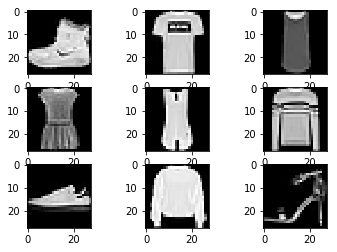

In [6]:
# load dataset
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

### 1. Prepare the data

First, we load the data. We know some things about the dataset. For example, we know that the images are all pre-segmented (e.g. each image contains a single item of clothing), that the images all have the same square size of 28×28 pixels, and that the images are grayscale. Therefore, we can load the images and reshape the data arrays to have a single color channel.

We also know that there are 10 classes and that classes are represented as unique integers. We can, therefore, use a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value. We can achieve this with the to_categorical() function.
So all of these 2 behaviors are implemented in the load_dataset() function below.

In [7]:
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255. We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range (0,1). This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

The prep_pixels() function below implement these behaviors and is provided with the pixel values for both the train and test datasets that will need to be scaled. This function must be called to prepare the pixel values prior to any modeling.

In [8]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

### 2. Define a model

Next, we need to define a baseline convolutional neural network model for the problem.

The model has two main aspects :
* the feature extraction front end comprised of convolutional and pooling layers and
* the classifier backend that will make a prediction.

For the convolutional front-end, we can start with a single convolutional layer with a small filter size (3,3) and a modest number of filters (32) followed by a max pooling layer. The filter maps can then be flattened to provide features to the classifier. Given that the problem is a multi-class classification, we know that we will require an output layer with 10 nodes in order to predict the probability distribution of an image belonging to each of the 10 classes. This will also require the use of a softmax activation function. Between the feature extractor and the output layer, we can add a dense layer to interpret the features, in this case with 100 nodes.

All layers will use the ReLU activation function and the He weight initialization scheme, both best practices.
We will use a conservative configuration for the stochastic gradient descent optimizer with a learning rate of 0.01 and a momentum of 0.9. The categorical cross-entropy loss function will be optimized, suitable for multi-class classification, and we will monitor the classification accuracy metric, which is appropriate given we have the same number of examples in each of the 10 classes.

The define_model() function below will define and return this model.

In [9]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### 3. Evaluate the model

After the model is defined, we need to evaluate it.

The model will be evaluated using 5-fold cross-validation. The value of k=5 was chosen to provide a baseline for both repeated evaluation and to not be too large as to require a long running time. Each test set will be 20% of the training dataset, or about 12,000 examples, close to the size of the actual test set for this problem.

The training dataset is shuffled prior to being split and the sample shuffling is performed each time so that any model we evaluate will have the same train and test datasets in each fold, providing an apples-to-apples comparison.

We will train the baseline model for a modest 5 training epochs with a default batch size of 32 examples. The test set for each fold will be used to evaluate the model both during each epoch of the training run, so we can later create learning curves, and at the end of the run, so we can estimate the performance of the model. As such, we will keep track of the resulting history from each run, as well as the classification accuracy of the fold.

The evaluate_model() function below implements these behaviors, taking the training dataset as arguments and returning a list of accuracy scores and training histories that can be later summarized.

In [10]:
# evaluate a model using k-fold cross-validation
#evaluate_model(dataX, dataY, n_folds=5, model_defined=define_model())
def evaluate_model(dataX, dataY, model_defined, btchsize, n_folds=5):
    scores, histories = [], []
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = model_defined
        #print(model.summary())
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=5, batch_size=btchsize, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

Once the model has been evaluated, we can present the results.

There are two key aspects to present:
* the diagnostics of the learning behavior of the model during training and
* the estimation of the model performance.
These can be implemented using separate functions.

First, the diagnostics involve creating a line plot showing model performance on the train and test set during each fold of the k-fold cross-validation. These plots are valuable for getting an idea of whether a model is overfitting, underfitting, or has a good fit for the dataset.

We will create a single figure with two subplots, one for loss and one for accuracy. Blue lines will indicate model performance on the training dataset and orange lines will indicate performance on the hold out test dataset. The summarize_diagnostics() function below creates and shows this plot given the collected training histories.

In [11]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    fig = plt.figure(figsize=(8,8))
    labels = ['train', 'test']
    for i in range(len(histories)):
        # plot loss
        plt.subplot(211)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(212)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.legend(labels)
    plt.show()

Next, the classification accuracy scores collected during each fold can be summarized by calculating the mean and standard deviation. This provides an estimate of the average expected performance of the model trained on this dataset, with an estimate of the average variance in the mean. We will also summarize the distribution of scores by creating and showing a box and whisker plot.

The summarize_performance() function below implements this for a given list of scores collected during model evaluation.

In [12]:
# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.title('Accuracy score')
    plt.show()

The following function is to drive the test harness by calling all the define functions above.

In [13]:
# run the test harness for evaluating a model
def run_test_harness(model, batchsize):
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY, model_defined=model , btchsize=batchsize)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)
    return histories, scores

In [96]:
model1 = define_model()

In [98]:
#model1.summary()

> 97.667
> 98.233
> 98.625
> 98.492
> 98.742


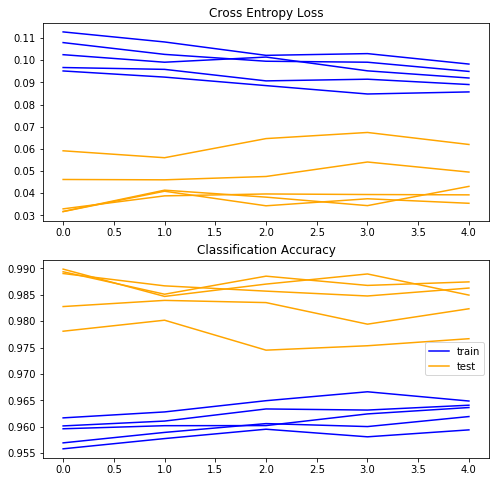

Accuracy: mean=98.352 std=0.382, n=5


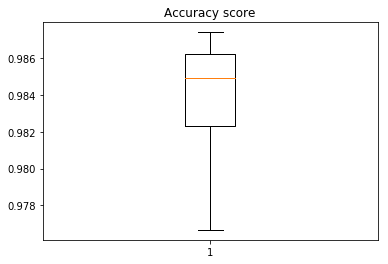

In [34]:
# entry point, run the test harness
hist,sco = run_test_harness(model1, batchsize=32)

#> 97.667
#> 98.233
#> 98.625
#> 98.492
#> 98.742

The x-axis is the number of epoch (here 5). So it from 0 to 4.

We can see that for each fold, the baseline model achieved an error rate below 5%. The accuracies are around 98%. These are good results.

Also looking at the figures, it seems like there is neither overfitting nor underfitting.

On average the accuracy of our model is 98%.

### 4. Improve model performance

Now it's time to improve our model performance in order to get good resultats for the prediction coming up. To do so we can either tune the parameters of the current model or try new architectures such as : LeNet-5 and ResNet.

#### 4.1 Tune the current model's parameters

We can now set the padding to the value 'same' (default value being 'valid') so that zero values are added around the input such that the output has the same size as the input.

We can also increase the number of filters used in the convolutional layer, as it can provide more opportunity for extracting simple features from the input images. This is especially relevant when very small filters are used, such as 3×3 pixels. In this change, we can increase the number of filters in the convolutional layer from 32 to double that at 64.

In [15]:
def define_model_tuned():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu',
                     kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [16]:
model2 = define_model_tuned()

> 89.667
> 91.983
> 93.133
> 94.225
> 95.142


/home/jgz/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


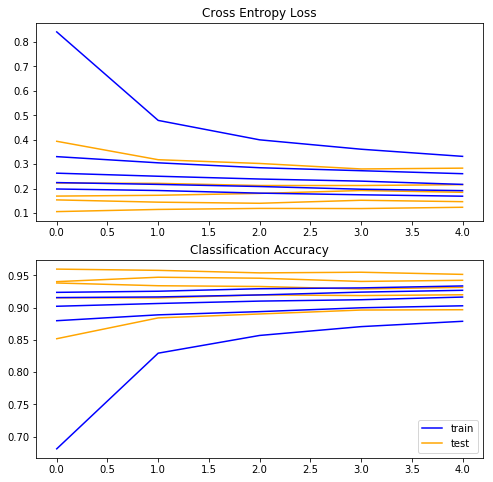

Accuracy: mean=92.830 std=1.903, n=5


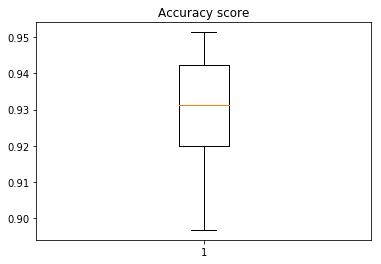

([<tensorflow.python.keras.callbacks.History at 0x7fd38845dd30>,
 [0.89666665, 0.91983336, 0.93133336, 0.94225, 0.9514167])

In [33]:
run_test_harness(model2, batchsize=32)

#> 89.667
#> 91.983
#> 93.133
#> 94.225
#> 95.142

Adding a padding and the number of filters doesn't improve that much the model. The accuracy on average is about 93% which is slightly lower than the accuracy of the first model.

#### 4.2 New architecture 1 : LeNet-5

In [35]:
def lenet5_model():
    model = Sequential()

    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
    model.add(AveragePooling2D())

    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D())

    model.add(Flatten())

    model.add(Dense(units=120, activation='relu'))

    model.add(Dense(units=84, activation='relu'))

    model.add(Dense(units=10, activation = 'softmax'))
    
    model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, optimizer=tensorflow.keras.optimizers.Adam(), metrics=['accuracy'])
    
    return model

In [36]:
model3 = lenet5_model()

> 85.517
> 89.150
> 89.608
> 90.208
> 92.075


/home/jgz/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


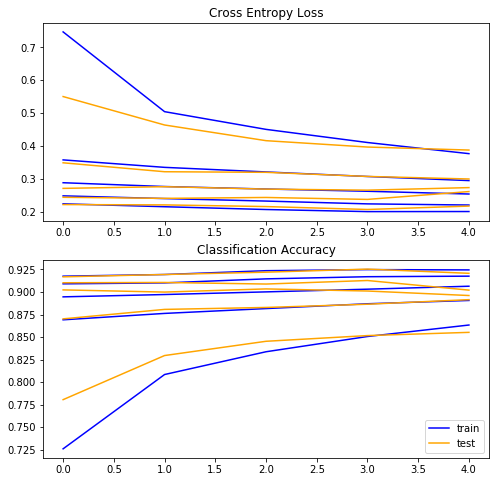

Accuracy: mean=89.312 std=2.143, n=5


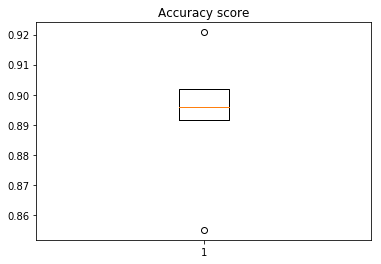

([<tensorflow.python.keras.callbacks.History at 0x7fd3a93d65c0>,
 [0.8551667, 0.8915, 0.89608335, 0.90208334, 0.92075])

In [37]:
run_test_harness(model3, batchsize=128)

#> 85.517
#> 89.150
#> 89.608
#> 90.208
#> 92.075

For LeNet-5 model, the accuracy is about 89%. It's even lower than the accuracy of the previous model. The train and test loss and accuracy seems to follow the same paterns, which is pretty good.

#### 4.3 New archictecture 2 : ResNet

In [50]:
# from keras' documentation
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [45]:
# from keras' documentation
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [63]:
# from keras' documentation
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=6)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [91]:
trainX, trainY, testX, testY = load_dataset()

In [90]:
depth = 20
input_shape=trainX.shape[1:]
model4 = resnet_v1(input_shape,depth)

In [66]:
model4.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])

Learning rate:  0.001


In [69]:
#run_test_harness(model4, batchsize=128)
#run_test_harness(model4, batchsize=32)

The running time of the command above is very long (more than 50 minutes and the first epoch is still running). Thus, we cannot provide the results of this model.
The idea was to say, as ResNet architecture give the best results over all the others so far, we think it can be the same on our data. But we cannot prove it, so we'll keep the first model as the best giving us the best accuracy overall.

In [115]:
# let's fit and save our best model (model3 : LeNet-5)

# fit the model
model3.fit(trainX, trainY, epochs=5, batch_size=32, verbose=0)

In [116]:
# save the model
model3.save('final_model3.h5')

In [117]:
# run the test harness for evaluating a model
def run_test_harness_BM():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # load model
    model = load_model('final_model3.h5')
    # evaluate model on test dataset
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))

In [118]:
run_test_harness_BM()

> 42.950


### 5. Make prediction

We can use our saved model to make a prediction on new images.

The model assumes that new images are grayscale, they have been segmented so that one image contains one centered piece of clothing on a black background, and that the size of the image is square with the size 28×28 pixels. So we'll try to predict the class of the image located in the repository. It's a pullover, so we expect class 2 as result.

First, we can load the image, force it to be grayscale format, and force the size to be 28×28 pixels. The loaded image can then be resized to have a single channel and represent a single sample in a dataset. The load_image() function implements this and will return the loaded image ready for classification.

In [112]:
# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, grayscale=True, target_size=(28, 28))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 1 channel
    img = img.reshape(1, 28, 28, 1)
    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img

In [119]:
# load an image and predict the class
def run_example():
    # load the image
    img = load_image('sample_image.png')
    # load model
    model = load_model('final_model3.h5')
    # predict the class
    result = model.predict_classes(img)
    print(result[0])

In [120]:
# make prediction
run_example()

#2

/home/jgz/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


2


## Conclusion

Overall, LeNet-5 architecture gave good results. We're sure that ResNet would have done a better job but unfortunately we couldn't run it.
The prediction at the end was also good, as it find out that the image belong to class 2, which stands for pullover.